# JPX: Tokyo Stock Exchange Prediction
Explore the Tokyo market with your data science skills


※　I think this competition is a competition that ranks the change rate Target of the closing price (Close) between the next day and the 2 days later for each stock on each date.

Understanding what to predict is a bit complicated, so I'd like to take a look at an easy-to-understand example.



In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

# 0.What to predict ? : Take a look at an example of sample submission

In [ ]:
sample = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv")
sample

In [ ]:
sample.nunique()

Predict Ranks by date and Securities Code (stocks).

Rank indicates the ranking of the change rate of the closing price (Close) of the next day and the next day for each of 2000 stocks, counting from the largest of 2000 stocks. (If the rate of change is large, it will be to plus direction, so if you buy it for 100 dollar, it will be 120 dollar. If the rate of change is small, it will be large to minus direction, so if you sell it for 100 dollar, it will be 80 dollar. This makes the benefit.)

It's a little difficult to understand, isn't it? Let's take a simple example.

# 1. Understand how to calculate scores and deepen your understanding of Rank

https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition

Here is how to calculate the score. It is difficult to understand in mathematical formulas, so I will try to understand them one by one.

Take a look at the train data. stock_prices.csv in train_files

In [ ]:
stock_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
stock_prices

In [ ]:
stock_prices["Date"] = pd.to_datetime(stock_prices["Date"])

Of these, Target is important.

# 1.1 Let's look at only one stock

In [ ]:
tmpdf = stock_prices[stock_prices["SecuritiesCode"]==1301].reset_index(drop=True)
tmpdf.head(3)

# Step 1 : Try to calculate TARGET (change rate of Close on the next day and the next day) by yourself.


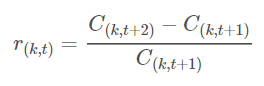

I think open is the price at the beginning of the day, close is the stock price when it closes. So close is the stock price at the end of the day.

In [ ]:
tmpdf["Close_shift1"] = tmpdf["Close"].shift(-1)
tmpdf["Close_shift2"] = tmpdf["Close"].shift(-2)

tmpdf["rate"] = (tmpdf["Close_shift2"] - tmpdf["Close_shift1"]) / tmpdf["Close_shift1"]
tmpdf

This understanding is OK because the Target and the rate calculated by myself match. (I will use the Target that is calculated from now on)

# Rank calculation.

First, let's take a look at only one day. * Please note that not all 2000 stocks have data depending on the date.

In [ ]:
stock_prices.head(3)

In [ ]:
tmpdf2 = stock_prices[stock_prices["Date"]=="2021-12-02"].reset_index(drop=True)
tmpdf2

Rank in descending order of Target. I do sort it for understanding.
Rank is tied to 0-1999, so don't forget -1 (if you don't enter it, you will get an error)

In [ ]:
tmpdf2["rank"] = tmpdf2["Target"].rank(ascending=False,method="first") -1 
tmpdf2 = tmpdf2.sort_values("rank").reset_index(drop=True)


In terms of meaning, the smaller the rank, the larger the rate of change to +, so it is profitable to buy it.
The larger the rank value, the greater the rate of change, so it is profitable to sell it.

# Step 3 Calculation of daily spread return of this day

https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition

If you look at, for the top 200 and bottom 200 of the rank, multiply the rate of change target of the closing price you just understood by weight (1 ~ 2). I'm not good at formulas, so I'll calculate it.

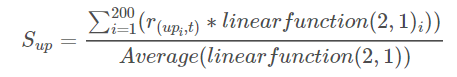

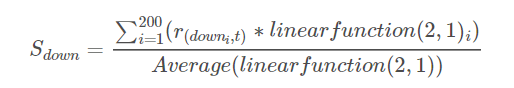

Consider only a rank of 200 from the top. (200 larger Targets)

In [ ]:
tmpdf2_top200 = tmpdf2.iloc[:200,:]
tmpdf2_top200

Calculate the top 200 weights and embed them in finweights

In [ ]:
weights = np.linspace(start=2, stop=1, num=200)
weights

In [ ]:
tmpdf2_top200["weights"] = weights
tmpdf2_top200.head(3)

Multiply this by target

In [ ]:
tmpdf2_top200["calc_weights"] = tmpdf2_top200["Target"] * tmpdf2_top200["weights"]
tmpdf2_top200.head(3)

The sum of this is divided by weight, Sup


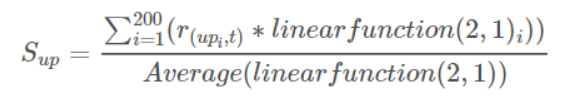


In [ ]:
Sup = tmpdf2_top200["calc_weights"].sum()/np.mean(weights)
Sup

Similarly, calculate Sdown by calculating 200 bottoms.

In [ ]:
tmpdf2_bottom200 = tmpdf2.iloc[-200:,:]
tmpdf2_bottom200 = tmpdf2_bottom200.sort_values("rank",ascending = False).reset_index(drop=True)
tmpdf2_bottom200

In [ ]:
tmpdf2_bottom200["weights"] = weights
tmpdf2_bottom200.head(3)

In [ ]:
tmpdf2_bottom200["calc_weights"] = tmpdf2_bottom200["Target"] * tmpdf2_bottom200["weights"]
tmpdf2_bottom200.head(3)

In [ ]:
Sdown = tmpdf2_bottom200["calc_weights"].sum()/np.mean(weights)
Sdown

## Calculate daily spread return

In [ ]:
daily_spread_return = Sup - Sdown
daily_spread_return

This is calculated every day, and the score is calculated by dividing the average value of daily_spread_return for a certain period by the standard deviation.

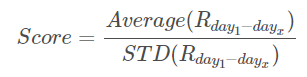

The following functions have put together that. Thank you for preparing.

In [ ]:

import numpy as np
import pandas as pd


def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

# 1.2 [Case verification] Score calculation: 

Let's calculate the score of this competition with a function only in 2021 where 2000 stocks are available.

# 1.2.1 Filtering for explanation

In [ ]:
idcount = stock_prices.groupby("Date")["SecuritiesCode"].count().reset_index()
idcount

In [ ]:
plt.plot(idcount["Date"],idcount["SecuritiesCode"])

Depending on the date, there are cases where there are not 2000 stocks, so only those with 2000 are pulled.

In [ ]:
idcount.loc[idcount["SecuritiesCode"]==2000,:]

It seems that 2000 pieces are available from December 23, 2020. For the easy understanding, let's calculate only for 2021.

In [ ]:
stock_prices2 = stock_prices.loc[stock_prices["Date"]>= "2021-01-01"].reset_index(drop=True)
stock_prices2

It seems that you have to prepare Rank yourself. I will put it out in one shot.

In [ ]:
stock_prices2["Rank"] = stock_prices2.groupby("Date")["Target"].rank(ascending=False,method="first") -1 
stock_prices2["Rank"] =stock_prices2["Rank"].astype("int") # floatだとエラー

In [ ]:
stock_prices2

In [ ]:
stock_prices2["Rank"].min()

Calculated below. Portfolio_size is the weight of 200 pieces above and below. toprank_weight_ratio means to multiply evenly spaced weights between 1-2.

In [ ]:
score = calc_spread_return_sharpe(stock_prices2, portfolio_size= 200, toprank_weight_ratio= 2)
score

And, the score in this period came out. The person with this big wins.

# 2.What do you predict the Rank from? (Look at the data)

First of all, there are many folders, so what does that mean?

* data_specifications : Folder with files that define what the columns in each file mean

* train_files : A data folder that covers the main training period.

* Supplemental_files : Probably, the latest stock price data will be updated in early May, early June, and one week before the end of the competition.

* example_test_files : An example of the file format provided at the time of submit. Since Target is not included, you can calculate by yourself from Close. 

## 2.1 For the time being, let's look only at the contents of the main train_files (the meaning of column shows data_specifications)

### 2.1.1 stock_prices

The core file of interest. Includes the daily closing price for each stock and the target column.

In [ ]:
stock_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
stock_prices.head(3)

In [ ]:
trades_spec = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv")
trades_spec

### 2.1.2 trades

In [ ]:
trades = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/trades.csv")
trades.head(3)

Aggregated summary of trading volumes from the previous business week.

In [ ]:
trades_spec = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv")
trades_spec

### 2.1.3 secondary_stock_prices

In [ ]:
secondary_stock_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/secondary_stock_prices.csv")
secondary_stock_prices.head(3)

The core dataset contains on the 2,000 most commonly traded equities but many less liquid securities are also traded on the Tokyo market. This file contains data for those securities, which aren't scored but may be of interest for assessing the market as a whole.

### 2.1.4 options

In [ ]:
options = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/options.csv")
options.head(3)

Data on the status of a variety of options based on the broader market. Many options include implicit predictions of the future price of the stock market and so may be of interest even though the options are not scored directly.

In [ ]:
options_spec = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/data_specifications/options_spec.csv")
options_spec

### 2.1.5 financials

In [ ]:
financials = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/financials.csv")
financials.head(3)

Results from quarterly earnings reports.

In [ ]:
stock_fin_spec = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv")
stock_fin_spec

# 2.2 stocklist : This is separate from the folder

In [ ]:
stock_list = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")
stock_list.head(3)

Relationship between Securities Code and company name

In [ ]:
stock_list_spec = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_list_spec.csv")
stock_list_spec

# 3. submit : time series api

time series api is

   Data comes for a certain period (for example, the first day) → Predict it → Submit it


→ Data will come for a certain period (for example, the second day) → Predict it → Submit it


→ Data will come for a certain period (for example, the 3rd day) → Predict it → Submit it


・ ・ ・ It repeats. This time, the submission deadline is 2022 / 7/5. It is said that the winners will be announced on 10/7 with the real data after that.

https://www.kaggle.com/code/sohier/basic-submission-demo

The basic ones are written in.

First do this

In [ ]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

The following for statement is. For the time being, let's take a look at one dose.

Rewrite Rank in sample_prediction,

Submit once with env.predict,

For the easy understanding, let's break once and see what's going on, but usually we don't break and just let it flow.

In [ ]:
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    
    break


In [ ]:
prices.head(3)

In [ ]:
options.head(3)

In [ ]:
financials.head(3)

In [ ]:
trades.head(3)

In [ ]:
secondary_prices.head(3)

In [ ]:
sample_prediction.head(3)

Edit and submit sample_prediction.head () here

# 3.1 Trial submit: Submit by substituting all the ranks of the last day as they are.

In [ ]:
stock_prices

Stock_prices in train_files earlier is up to 2021-12-03.

In [ ]:
supplemental_stock_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")
supplemental_stock_prices

Stock_prices in supplemental_files, which will be updated from time to time, is until 2022-02-28.
I will paste the rank of 2022-02-28 as it is and submit it.

In [ ]:
supplemental_stock_prices["Rank"] = supplemental_stock_prices.groupby("Date")["Target"].rank(ascending=False,method="first") -1
supplemental_stock_prices.head(3)

In [ ]:
finday = supplemental_stock_prices[supplemental_stock_prices["Date"]=="2022-02-28"].reset_index(drop=True)
finday

In [ ]:
finday[finday["Rank"]==finday["Rank"].iloc[0]]

In [ ]:
finday["Rank"] = finday["Rank"].astype("int")

Make it into a dictionary

In [ ]:
findaydict = dict(zip(finday["SecuritiesCode"],finday["Rank"]))

Edit sample_prediction for submit

In [ ]:
sample_prediction.head(3)

In [ ]:
sample_prediction["Rank"]  = sample_prediction["SecuritiesCode"].map(findaydict)
sample_prediction

Submit once

In [ ]:
env.predict(sample_prediction)

## Submit the rest with a for statement 
(For the easy understanding, I broke once in ↑, but usually only the following image)

In [ ]:
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    
    sample_prediction['Rank'] = sample_prediction["SecuritiesCode"].map(findaydict)
    env.predict(sample_prediction)


In [ ]:
sample_prediction

# Thank you for reading.